In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import *
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as tf
import os
from torch.optim import RMSprop
from torchvision.utils import make_grid
from pylab import plt
#import Mod.res_block as resblock
import Liblinks.utis as f_s
from Liblinks.sn_lib import *
from Liblinks.resblock import *

In [2]:
#基本配置
path=os.path.abspath('../../dataset/GetChu_aligned2/')
num_chann=np.array([64*8,64*4,64*2,64,64])
dnum_chann=np.array([64,64*2,64*4,64*8])
img_size=64
noise_size=128
im_chann=3
bat_size=20
tr_epoch=100000
worker=2
gpu=True
#clamp_num=0.01
learningr=0.00001
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

transform1=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),#读成tensor，归一化到0~1区间
    transforms.Normalize([0.5]*3,[0.5]*3)#归一化到-1到1区间
])


In [3]:
class Gan_data(Dataset):
    def __init__(self,root,transform,augment=None):
        self.image_files=np.array([x.path for x in os.scandir(root) if x.name.endswith(".jpg")])
        self.transform=transform
        self.augment=augment
        
        
    def __getitem__(self,index):
        
        
        return self.transform(Image.open(self.image_files[index]))
    
    def __len__(self):
        return len(self.image_files)

In [4]:
#生成器定义

class Generat(nn.Module):
    def __init__(self,channel=64,dim_z=128,bottom_width=4,n_cls=0):
        self.bottom_width=bottom_width
        self.dim_z=dim_z
        self.num_classes=n_cls
        super(Generat,self).__init__()
        self.l1=nn.Linear(dim_z,(bottom_width ** 2) * channel * 16)
        #print(self.l1)
        self.b1=GBlock(channel * 16, channel * 16,upsample=True,n_cls=n_cls)
        self.b2=GBlock(channel * 16, channel * 8,upsample=True,n_cls=n_cls)
        self.b3=GBlock(channel * 8, channel * 8,upsample=True,n_cls=n_cls)
        self.b4=GBlock(channel * 8, channel * 4,upsample=True,n_cls=n_cls)
        self.b5=GBlock(channel * 4, channel * 2,upsample=True,n_cls=n_cls)
        self.b6=GBlock(channel * 2, channel    ,upsample=True,n_cls=n_cls)
        self.bn1=nn.BatchNorm2d(channel)
        self.con1=nn.Conv2d(channel,3,kernel_size=3, stride=1, padding=1)
        self.actf=nn.ReLU(inplace=True)
        self.tanhf=nn.Tanh()
        
        
    def forward(self,x):
        x=self.l1(x)
        x=x.view(x.size(0),-1,self.bottom_width,self.bottom_width)
        #print(x.size())
        x=self.b1(x)
        x=self.b2(x)
        x=self.b3(x)
        x=self.b4(x)
        x=self.b5(x)
        x=self.b6(x)
        x=self.bn1(x)
        x=self.actf(x)
        x=self.con1(x)
        x=self.tanhf(x)
        return x
        

In [5]:
#判别器定义
#backbone网络
class BackBoneNet(nn.Module):
    def __init__(self,channel=64,n_cls=0):
        super(BackBoneNet,self).__init__()
        self.boneNet=nn.Sequential(OptimizedBlock(3,channel),
                                  Block(channel,channel*2,downsample=True),
                                   Block(channel*2,channel*4,downsample=True),
                                   Block(channel*4,channel*8),
                                  Block(channel*8,channel*8,downsample=True),
                                  Block(channel*8,channel*16,downsample=True),
                                   Block(channel*16,channel*16))
        
    def forward(self,input):
        return self.boneNet(input)
    
    
    
    
class Discrim(nn.Module):
    def __init__(self,in_nu,hiddent_nu,out_nu,n_cls=0):#out_nu为输出维度，判别器维度为1
        super(Discrim,self).__init__()
        self.avg=nn.AdaptiveAvgPool2d(1)
        self.FC=nn.Sequential(SNLinear(in_nu,hiddent_nu),
                              nn.ReLU(inplace=True)
                              )
        self.FD=nn.Sequential(SNLinear(hiddent_nu,out_nu))
        if n_cls >0:
            self.l_y=SNEmbedCLS(n_cls,hiddent_nu)
        
    def forward(self,x,y=None):
        x=self.avg(x)
        x=x.view(x.size(0),-1)#把每个batch变成向量，然后输入全连接层
        h=self.FC(x)
        output=self.FD(h)
        #print(output)
        if y is not None:
            w_y=self.l_y(y)
            cls_y=torch.mul(w_y,h).sum(dim=1,keepdim=True)#要求两个行向量做内积
            #print(cls_y)
            output+=cls_y
        return output
        
        
class Discr_net(nn.Module):#用这个
    def __init__(self,channel):
        super(Discr_net,self).__init__()
        self.CNN=nn.Sequential(OptimizedBlock(3,channel),
                                  Block(channel,channel*2,downsample=True),
                                   Block(channel*2,channel*4,downsample=True),
                                   Block(channel*4,channel*8),
                                  Block(channel*8,channel*8,downsample=True),
                                  Block(channel*8,channel*16,downsample=True),
                                   Block(channel*16,channel*16))
        self.avg=nn.AdaptiveAvgPool2d(1)
        self.FC=nn.Sequential(SNLinear(channel*16,1024),
                              nn.ReLU(inplace=True)
                              )
        self.FD=nn.Sequential(SNLinear(1024,1))
        
    def forward(self,x):
        x=self.CNN(x)
        x=self.avg(x)
        x=x.view(x.size(0),-1)
        x=self.FC(x)
        output=self.FD(x)
        
        return output

In [6]:
discriminator=Discr_net(64)
generator=Generat()

#optimizerD = RMSprop(discriminator.parameters(),lr=learningr) 

#optimizerG = RMSprop(generator.parameters(),lr=learningr) 


optimizerD=torch.optim.Adam(discriminator.parameters(),lr=learningr)
optimizerG=torch.optim.Adam(generator.parameters(),lr=learningr)


In [7]:
#查看参数
for layer in discriminator.parameters():
    print(layer)

Parameter containing:
tensor([[[[-4.0587e-02,  1.7467e-01, -5.3778e-02],
          [ 3.1818e-03, -6.4391e-03,  1.0514e-01],
          [-1.3009e-01, -6.6645e-02, -1.4815e-01]],

         [[ 6.9415e-02, -4.3472e-02,  5.4902e-02],
          [-5.5407e-02,  6.6101e-02,  1.9128e-01],
          [-1.0916e-01,  1.2975e-01,  1.3587e-01]],

         [[ 1.4349e-01,  6.6988e-02, -6.4402e-03],
          [ 7.3511e-02, -2.2849e-02,  5.1565e-02],
          [ 1.5372e-02, -2.0518e-03, -3.3912e-02]]],


        [[[ 3.8642e-02, -1.5184e-01, -6.7398e-03],
          [ 8.8279e-02, -7.4511e-02,  4.6469e-02],
          [-1.4427e-01, -5.3730e-02, -2.4877e-02]],

         [[-5.5110e-02,  1.0612e-03, -1.2028e-01],
          [ 5.6523e-02,  1.8544e-02,  1.8708e-01],
          [ 1.3079e-01,  1.5977e-01,  1.4727e-01]],

         [[ 2.8611e-03, -8.0865e-02, -1.3933e-02],
          [-1.3956e-01, -1.2917e-01, -1.1241e-01],
          [-4.7105e-02, -2.9581e-02,  5.1769e-02]]],


        [[[-1.4941e-01, -8.3874e-02,  3.7033

Parameter containing:
tensor([[[[-1.0818e-02, -2.5313e-02,  1.6758e-02],
          [-2.7983e-02,  1.5909e-02, -1.1401e-02],
          [ 2.8015e-02,  1.2043e-02,  1.8503e-02]],

         [[ 3.0517e-03, -6.8128e-03, -1.1820e-02],
          [ 6.8546e-04,  2.1866e-02, -2.1107e-02],
          [-2.2533e-02, -7.5066e-03,  4.4679e-03]],

         [[ 2.6337e-02, -2.5832e-02, -1.4233e-02],
          [ 1.4681e-02, -6.8906e-03,  2.8898e-02],
          [ 1.9193e-02,  1.0119e-02, -2.2570e-02]],

         ...,

         [[ 1.4162e-02,  1.3807e-02,  2.6948e-03],
          [-1.4079e-02,  2.4132e-02, -3.3358e-03],
          [ 2.6010e-02,  5.1778e-03, -3.2044e-03]],

         [[-5.4672e-03, -1.9874e-02, -1.7622e-02],
          [-1.0011e-02, -4.1611e-03,  2.3063e-02],
          [-1.4552e-02, -1.3128e-03,  2.0378e-02]],

         [[ 1.9111e-02, -2.0529e-02, -1.2830e-02],
          [-1.8549e-02, -1.2167e-03,  2.6578e-02],
          [-2.1775e-03, -1.6080e-02,  1.0989e-03]]],


        [[[ 7.1403e-04, -2.7701

Parameter containing:
tensor([[[[-1.0012e-02,  1.5146e-03, -3.2499e-03],
          [-9.5457e-03,  7.8359e-04,  2.2334e-03],
          [-1.0267e-02, -8.3474e-03,  1.1475e-02]],

         [[-1.1240e-02,  1.4252e-02,  7.1760e-03],
          [ 7.0997e-03,  6.1874e-03, -4.7620e-03],
          [ 1.2971e-03,  7.6686e-03, -1.9095e-03]],

         [[-4.1921e-03,  1.2300e-02,  1.2764e-02],
          [-1.2614e-02, -8.9304e-03,  3.6492e-04],
          [-1.1180e-02, -1.0467e-02,  6.4002e-03]],

         ...,

         [[-9.9074e-03,  1.2337e-02, -1.0131e-03],
          [-9.7755e-04, -2.5384e-04,  1.0951e-02],
          [ 4.9143e-03,  9.0150e-03, -1.3985e-02]],

         [[-4.8206e-03,  6.0435e-03,  6.1727e-03],
          [ 1.8613e-03, -7.2206e-03,  9.5525e-04],
          [-1.3088e-02, -4.3074e-03, -8.0098e-03]],

         [[-6.8614e-03,  3.2070e-03, -5.5413e-03],
          [ 1.2042e-03,  6.5312e-03, -9.6252e-03],
          [-1.4609e-02, -9.3303e-03, -3.8026e-03]]],


        [[[ 1.0236e-02, -6.3319

Parameter containing:
tensor([[[[ 9.2404e-03, -8.8435e-03, -3.0315e-03],
          [-1.7442e-03,  4.7549e-03,  7.6271e-03],
          [-5.0760e-03,  1.4355e-03,  3.8663e-03]],

         [[ 5.7527e-03, -6.5968e-03, -1.2040e-03],
          [-2.4487e-03, -6.7462e-03, -1.0669e-03],
          [-2.7343e-03,  6.0580e-03, -6.5358e-03]],

         [[-5.0915e-03, -8.5257e-03,  9.8774e-03],
          [-8.9007e-03, -7.0177e-03,  3.9414e-06],
          [ 5.1733e-03,  3.5634e-03, -3.7766e-03]],

         ...,

         [[-6.0401e-03, -2.0559e-03, -3.3861e-03],
          [ 8.2794e-03,  5.0029e-03,  4.0786e-04],
          [ 6.5035e-03, -8.6025e-04, -7.3457e-03]],

         [[-2.7890e-03, -6.2602e-03,  4.1376e-03],
          [-2.7369e-03, -7.4606e-03,  6.1419e-03],
          [-7.8817e-03,  2.7896e-04,  1.4853e-03]],

         [[-6.2616e-03, -5.5872e-03,  1.1280e-04],
          [ 9.7285e-03,  9.1930e-03,  6.9527e-03],
          [ 4.5841e-03, -5.8697e-03, -3.7328e-03]]],


        [[[ 9.7891e-03, -3.9425

In [7]:
#训练准备
fix_noise=torch.randn(bat_size,noise_size)
dataset=Gan_data(path,transform1)
data_trainer=DataLoader(dataset,bat_size,shuffle = True,num_workers=worker)
if gpu:
    fix_noise=fix_noise.cuda()
    generator.cuda()
    discriminator.cuda()
    
one=torch.ones([1],dtype=torch.float)
mione=one*-1

200
400
600
800
1000
1200
1400
1600
200
400
600
800
1000
1200
1400
1600
tensor([[ 0.8158,  1.9035,  0.6515,  ...,  1.8202,  0.2579, -1.3338],
        [ 0.7465, -1.7142,  0.0229,  ...,  1.8779,  0.0356,  1.2320],
        [ 1.1941, -1.2228, -1.5219,  ..., -0.5543, -0.5635,  1.6730],
        ...,
        [-1.3385, -1.2827, -0.0616,  ..., -0.0976, -2.0831,  0.5498],
        [-0.8871, -0.5996,  0.1064,  ...,  0.2282,  1.0357,  0.2431],
        [-0.7283, -1.3330,  0.2460,  ...,  0.6176,  1.5296, -1.9495]],
       device='cuda:0')
tensor([[[[-1.6413e-02,  4.8756e-03,  2.6113e-02,  ...,  1.7639e-02,
           -2.5438e-02, -2.1476e-02],
          [ 4.0262e-02, -1.2636e-01, -4.2760e-02,  ..., -2.0458e-02,
           -4.5488e-02,  2.9436e-02],
          [-1.8364e-02, -6.7942e-02,  4.4561e-03,  ..., -1.2882e-02,
           -4.2535e-02,  5.6433e-02],
          ...,
          [-1.8833e-02, -1.3219e-02,  1.7751e-03,  ..., -2.0281e-02,
            7.6699e-03,  2.0846e-02],
          [-6.8948e-02, -4.

200
400
600


KeyboardInterrupt: 

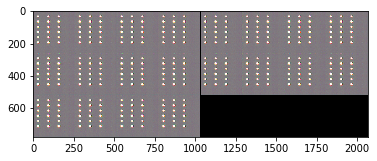

In [8]:
for epoch in range(tr_epoch):
    for i,data in enumerate(data_trainer,0):
        if (i+1)%200==0:
            print(i+1)
        input=data
        noise = torch.randn(input.size(0),noise_size)
        #print(len(data_trainer))
        if gpu:
            one=one.cuda()
            mione=mione.cuda()
            input=input.cuda()
            noise=noise.cuda()
            
        #for para in discriminator.parameters():
        #    para.data.clamp_(-clamp_num,clamp_num)
            
        discriminator.zero_grad()
        ## train netd with real img
        output=discriminator(input).mean().view(1)
        #if epoch>(tr_epoch-3):
        #    ioOut=np.append(ioOut,output.cpu().detach().numpy())
        #output.backward()
        ## train netd with fake img
        fake_pic=generator(noise).detach()
        output2=discriminator(fake_pic).mean().view(1)
        output2=output2-output#
        output2.backward()
        optimizerD.step()
        
        if (i+1)%5 ==0:
            generator.zero_grad()
            noise.data.normal_(0,1)
            fake_pic=generator(noise)
            output=discriminator(fake_pic).mean().view(1)
            output.backward(mione)#
            optimizerG.step()
            if i%100==0:pass
    
    
    if (epoch+1)%2==0:
        print(fix_noise)
        fake_u=generator(fix_noise)
        #print(fake_u)
        imgs = make_grid(fake_u.data*0.5+0.5).cpu() # CHW
        plt.imshow(imgs.permute(1,2,0).numpy()) # HWC
        outprint=tf.to_pil_image(imgs)
        outprint.save('./results/'+str(epoch+1)+'th epoch SNGANanime.png')
        
    #if epoch>(tr_epoch-3):
       # minmax=np.append(minmax,max(ioOut))
       # minmax=np.append(minmax,min(ioOut))
       # np.savetxt('out.txt',ioOut)
       # np.savetxt('minmax.txt',minmax)
        
    if (epoch+1)%20000==0:
        torch.save(generator.state_dict(),'./models/'+str(epoch+1)+'SNGANanime.pkl')
        torch.save(discriminator.state_dict(),'./models/'+str(epoch+1)+'SNGANanime.pkl')